In [1]:
% matplotlib inline

# Artificial Neural Networks

Here we will take a closer look at Neural Netorks, also known as Artificial Neural Networks (ANN) to destinuish them from their biological counterparts and Convolutional Neural Networks (CNN); which will be covered in the next session.

ANNs simulate the brain architecture in that neurons take gets input from synapses and give output to other neurons, thereby forming a directed graph.  

![General neural net graph](./images/general-ann.png)

The topology of this graph can be quite diverse, however we will start with a simple example. We will tag some nodes as special input nodes and some as special output nodes. This is were we will attach the input-output training data to later. The rest of the nodes are simply called "hidden nodes"

![Simple ANN](./images/Artificial_neural_network.svg)

A single neuron takes multiple inputs $x_i$ and give a single output (possible to more than one reciever). The inputs are weighted by some $\theta_i$ (including the bias $\theta_0$) to compute an *activation*

$$z = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n$$

In [2]:
def activation(x, theta):
    answer = theta[0]
    for i in range(len(x)):
        answer += x[i]*theta[i+1]
    return answer

However the activation is typically passed through an activation function. This introduces non-linearity into the formulation which greatly helps in generalizing to complex problems. Different activation functions are available, but the four quite commonly used are the sigmoid, rectified linear unit (relu), tanh and leaky relu

## Activation functions

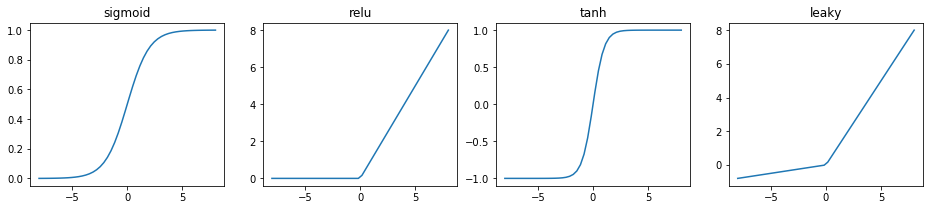

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(z):
    return 1 / (1+np.exp(-z))

def relu(z):
    return np.maximum(z,0)

def tanh(z):
    return np.tanh(z)

def leaky(z):
    return np.maximum(z, .1*z)

z = np.linspace(-8,8) # define evaluation some evaluation points

# plot the four different functions
f,ax = plt.subplots(1,4, figsize=(16,3))
ax[0].plot(z, sigmoid(z))
ax[1].plot(z, relu(z))
ax[2].plot(z, tanh(z))
ax[3].plot(z, leaky(z))
ax[0].set_title('sigmoid')
ax[1].set_title('relu')
ax[2].set_title('tanh')
ax[3].set_title('leaky')
plt.show()


a single neuron with input weights $\theta_i$ can then be programmed as

In [4]:
def neuron(x,theta):
    return sigmoid(activation(x,theta))

if one choses the sigmoid activation function. The entire network described above can be written as

In [5]:
# define some input vector
x = [1,3,13]

# compute output for hidden units
a1 = neuron(x, [3,1,1,1]) # output from hidden neuron 1 using weights [3,1,1,1] (first weight is the bias)
a2 = neuron(x, [1,1,2,1]) # output from hidden neuron 2 using weights [1,1,2,1]
a3 = neuron(x, [0,3,2,1]) # output from hidden neuron 2 using weights [0,3,2,1]
a4 = neuron(x, [2,0,0,1]) # output from hidden neuron 2 using weights [2,0,0,1]
a  = [a1,a2,a3,a4]      # wrap all hidden values into a vector

# compute output nodes
y1 = neuron(a, [1,0,0,1,3]) # output neuron 1 using weights [1,0,0,1,3] (first weight is the bias)
y2 = neuron(a, [1,3,9,1,0]) # output neuron 2 using weights [1,3,9,1,0]

We note that every neuron $i$ has a different weight $\theta_j$ and we often denote $\Theta_{ij}$

$$z = \Theta^{(1)} \left[\begin{array}{c} 1 \\ x \end{array}\right]$$

where, in this case we have

$$ \Theta^{(1)} = \left[ \begin{array}{cccc} 3 & 1 & 1 & 1 \\ 1 & 1 & 2 & 1 \\ 0 & 3 & 2 & 1 \\ 2 & 0 & 0 & 1\end{array}\right]$$

Then we compute the activation function (for instance the sigmoid function $\sigma$) and pass this to the next level of the network

$$ a = \sigma(z)$$

Likewise, the output nodes will also have different weights and we write

$$y = \sigma\left(\Theta^{(2)} \left[ \begin{array}{c}1\\a\end{array}\right]\right)$$

$\Theta^{(2)} =\left[\begin{array}{ccccc} 1 & 0 & 0 & 1 & 3 \\ 1 & 3 & 9 & 1 & 0 \end{array}\right]$ in this particular case. This vectorization allow us to create fast implementations of neural networks. $x$ and $y$ are as usual treated as the input and output respectively, while intermediate results are denoted $z$. 

Due to the optimzation possibilities, these *feed forward* networks have become very popular. We can extend this be adding more layers to it. By adding another layer we can start with a vector $x$, then compute a vector $z_1$ using a matrix of weights $\Theta^{(1)}$. Subsequently we compute a vector $z_2$ using a matrix of weights $\Theta^{(2)}$ followed by an output using $\Theta^{(3)}$, giving the following network

![Neural network with 2 hidden layers](./images/Artificial_neural_network_2layers.svg)

We can control the architecture of the network and the activation functions used, but will not manually specify the weights $\Theta$. This is trained using optimization algorithms using [backpropagation](https://en.wikipedia.org/wiki/Backpropagation). Note that the addition of multiple hidden layers gives rise to the term **deep** neural networks.

In [6]:
def predict(Theta1, Theta2, X):
    if X.ndim == 1:
        X = np.reshape(X, (-1,X.shape[0]))
    m = X.shape[0]
    p = np.zeros((m,1))
    X = np.column_stack((np.ones((m,1)), X))
    a2 = sigmoid( np.dot(X,Theta1.T) )
    a2 = np.column_stack((np.ones((a2.shape[0],1)), a2))
    a3 = sigmoid( np.dot(a2,Theta2.T) )
    p = np.argmax(a3, axis=1)
    return p + 1

# Architecture of Deep Neural Network, Cost Function and Regularization
<img src='./images/dnncost.png'>

# Solve using Keras with Tensorflow backend

We will now create a neural network to be for recoqnizing hand-written digits using the Keras library. First we will download and inspect the dataset.

In [10]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)
print(X_test.shape)

Using TensorFlow backend.


11493376/11490434 [==============================] - 6s 1us/step

    This is a set of 60,000 images (28x28 pixels grayscale) of hand-written digits. We can display the first few images

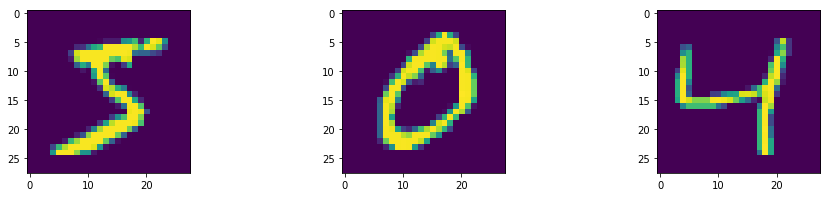

In [11]:
import matplotlib.pyplot as plt

f,ax = plt.subplots(1,3, figsize=(16,3))
ax[0].imshow(X_train[0])
ax[1].imshow(X_train[1])
ax[2].imshow(X_train[2])
plt.show()

In [12]:
# by inspecting the training labels, we see what these images are ment to show
print(y_train[0:3])

[5 0 4]


We will now convert the input data to the right representation


In [13]:
from sklearn.preprocessing import LabelBinarizer

# all inputs are defined as vectors, i.e. we collapse a 28x28 image to a 784 feature vector
# all inputs should be scaled to the range [0,1] (images are in the range [0,255])
X  = X_train.reshape(60000,784) / 255
Xt = X_test.reshape( 10000,784) / 255

# all outputs are defined as categorical values. We do a one-hot encoding of these
categorical_transform = LabelBinarizer().fit(np.arange(10)) # labels are in the range [0,10]
y  = categorical_transform.transform(y_train)
yt = categorical_transform.transform(y_test)

print(y[:10,:])
print(y_train[:10])

[[0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]
[5 0 4 1 9 2 1 3 1 4]


We define a convenience method to display multiple images and show these as scaled grayscale images

In [14]:
import math

def displayData(X, example_width=None):
    m,n = X.shape
    plt.figure(figsize=(16,16))
    if X.ndim == 1:
        X = np.reshape(X, (-1,m))
    if not example_width or not 'example_width' in locals():
        example_width = int(round(math.sqrt(X.shape[1])))
    example_height = n / example_width
    display_rows = int(math.floor(math.sqrt(m)))
    display_cols = int(math.ceil(m / display_rows))
    pad = 1
    display_array = -np.ones((pad + display_rows * int(example_height + pad),  pad + display_cols * int(example_width + pad)))
    curr_ex = 1
    for j in range(1,display_rows+1):
        for i in range (1,display_cols+1):
            if curr_ex > m:
                break
            max_val = max(abs(X[curr_ex-1, :]))
            rows = pad + (j - 1) * (int(example_height) + pad) + np.array(range(int(example_height)))
            cols = pad + (i - 1) * (int(example_width)  + pad) + np.array(range(int(example_width)))
            display_array[rows[0]:rows[-1]+1 , cols[0]:cols[-1]+1] = np.reshape(X[curr_ex-1, :], (int(example_height), int(example_width)), order="F") / max_val
            curr_ex += 1
            if curr_ex > m:
                break
    h = plt.imshow(display_array.T, vmin=-1, vmax=1, cmap='gray')
    plt.axis('off')
    plt.show(block=False)
    return h, display_array

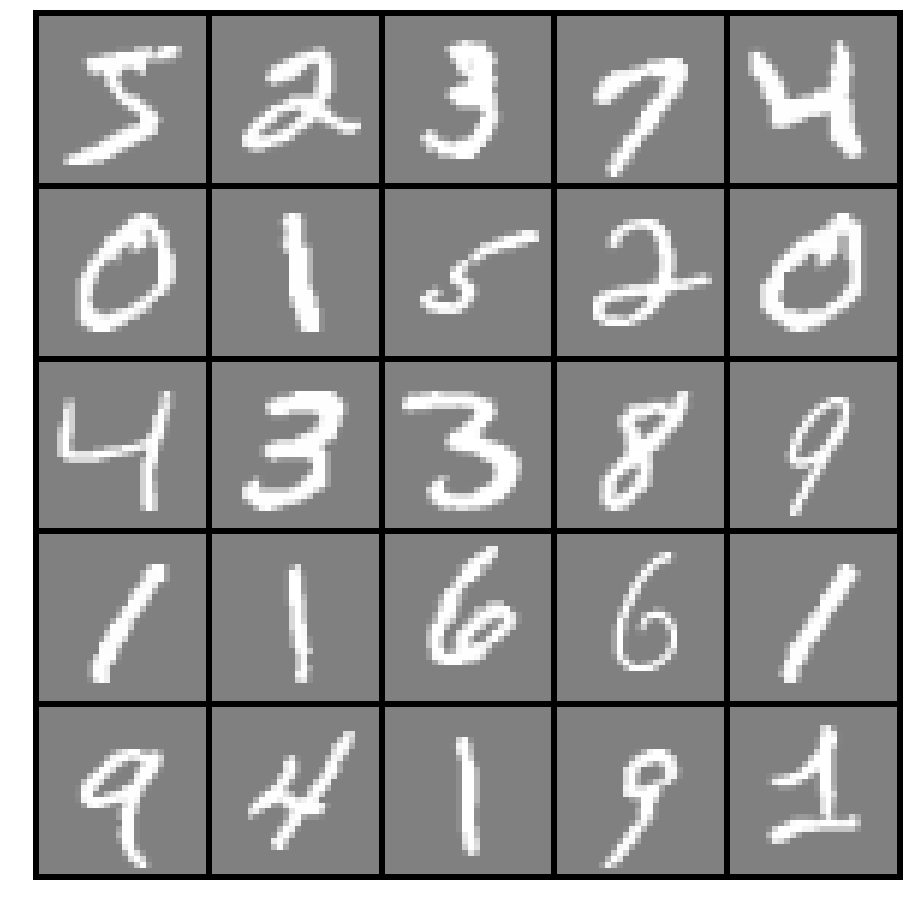

In [15]:
displayData(X[:25,:]);

We will now create a Neural Network model in Keras using the Sequential model

In [16]:
from keras.models import Sequential
from keras.layers import Dense

# create a model of sequential layers 
model = Sequential()

# add the first layer, this *requires* you to specify the input dimension (our 28*28=784 px images)
model.add(Dense(input_dim=784, units = 100, activation='sigmoid'))

# add the second layer. All layers require you to specify the number of neurons (units)
model.add(Dense(               units =  49, activation='sigmoid'))

# the third and final output layer. We here use the 'softmax' activation function since we want to classify
# the numbers [0-9] with a percentage prediction
model.add(Dense(               units =  10, activation='softmax'))

# finish the model and compile it so it is ready for training
model.compile(optimizer= 'adam',                     
              loss     = 'categorical_crossentropy',
              metrics  = ['accuracy'])

We now train the model on the training set. Training is the most time-consuming task of any machine learning project. This small example will train fairly quickly, but it is not unreasonable that this process can take hours, or even days, to complete for large-scale models

In [17]:
model.fit(X, y,
         epochs=10,
         batch_size=100,
         validation_data=(Xt,yt))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 44us/step - loss: 0.8007 - acc: 0.8253 - val_loss: 0.3272 - val_acc: 0.9142

Using a relatively small network, we still achieve an accuracy of over 99% on the training set and 97% on the test test. 

We now use our model on one of the test images to manually make a prediction. Remember that the test images are *not* used for updating the weights, so this is considered an unseen example image by the model

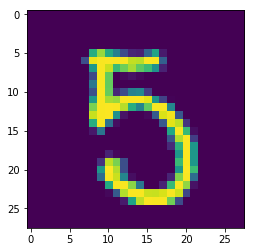

This is actually a 5

[[  3.20391919e-05   1.40476222e-05   3.29189334e-07   1.06309145e-03
    1.33755775e-05   9.98173594e-01   1.05954473e-06   3.72891827e-06
    2.36149732e-04   4.62559372e-04]]

99.81735944747925 % chance of this being a 5


In [18]:
i = 207 # choose one test image index

# show one of the test images
plt.imshow(X_test[i,:,:])
plt.show()
print('This is actually a', y_test[i]) # this is what it is *supposed* to be
print()

# do a prediction using our model
prediction = model.predict(X_test[i,:,:].reshape(1,28*28)) # remember to roll the image data into a vector


# the prediction is a vector of 10 (output nodes) with % probability of that being the shown digit (softmax function)
print(prediction)
print()
print('{} % chance of this being a {}'.format(prediction[0,y_test[i]]*100, y_test[i]))

## Model interpreation

Usually the weights are quite opaque, meaning that they are hard to interpret. In many applications this is not a problem; as the saying goes "all models are wrong, some are usefull". However if one wants a better understanding of what the model does, one can look at the equations. The predictions appear as a sequence of matrix-vector multiplications followed by application of the activation function. Ignoring the bias for now, they take the form:

$$ z_1 = \sigma\left( \Theta^{(1)} x  \right) \\
   z_2 = \sigma\left( \Theta^{(2)} z_1\right) \\
   y   = \sigma\left( \Theta^{(3)} z_2\right) $$

for our 3-layer neural network. Seing as the activation function, all take low values and map thems them to other low values and likewise for high values (monotonly growing function), it is not unreasonable to assume that a good approximation of neural importance comes from omitting the activation function to get

$$ y \approx \Theta^{(3)} \Theta^{(2)} \Theta^{(1)} x $$

If we call $\Theta = \Theta^{(3)} \Theta^{(2)} \Theta^{(1)}$, then this matrix will map from 784 image pixels to 10 digit predictions. We may get this matrix by

In [19]:
theta1 = model.layers[0].get_weights()[0] # returns a tuple of weights and the bias, we only care about weights now
theta2 = model.layers[1].get_weights()[0]
theta3 = model.layers[2].get_weights()[0]

print(theta1.shape)
print(theta2.shape)
print(theta3.shape)
# keras stores the weights as the transpose of the above, so we correct these
theta1 = theta1.T
theta2 = theta2.T
theta3 = theta3.T
theta = theta3.dot(theta2.dot(theta1))
print(theta.shape)

(784, 100)
(100, 49)
(49, 10)
(10, 784)


Seing as the inputs are considered image pixels, we may now draw reinpret the effect of $\Theta$ as image pixels. We reshape from 784 to (28,28) and draw the 10 images resulting from this

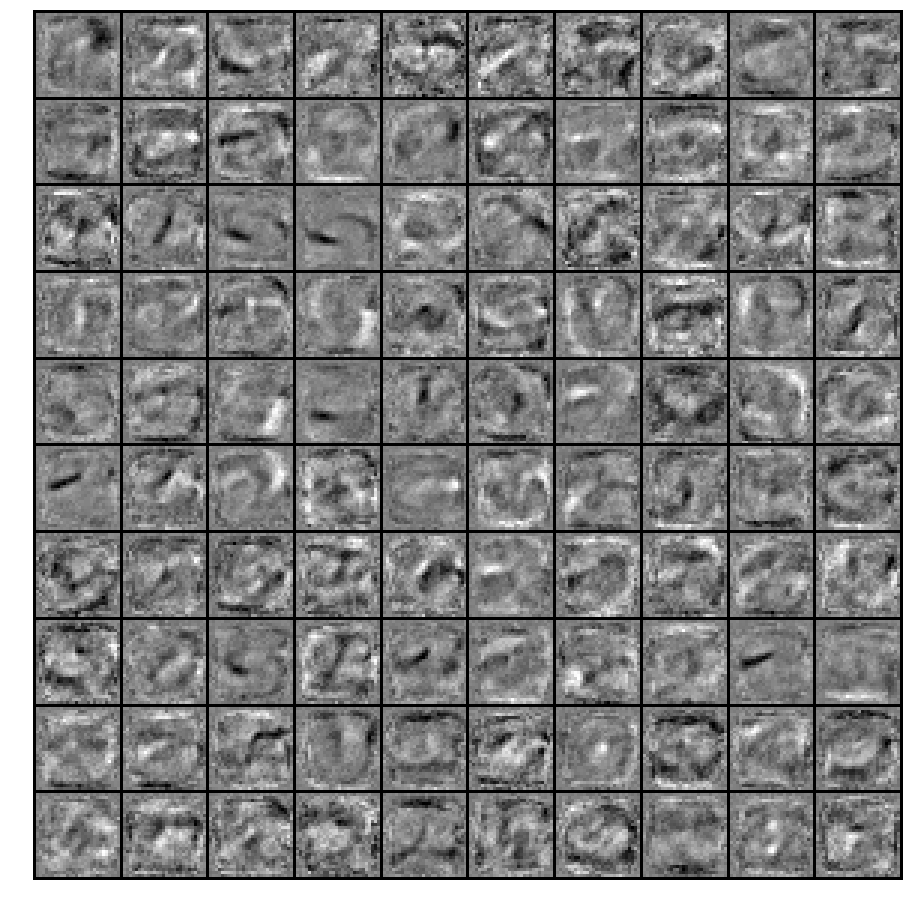

In [20]:
displayData(theta1);

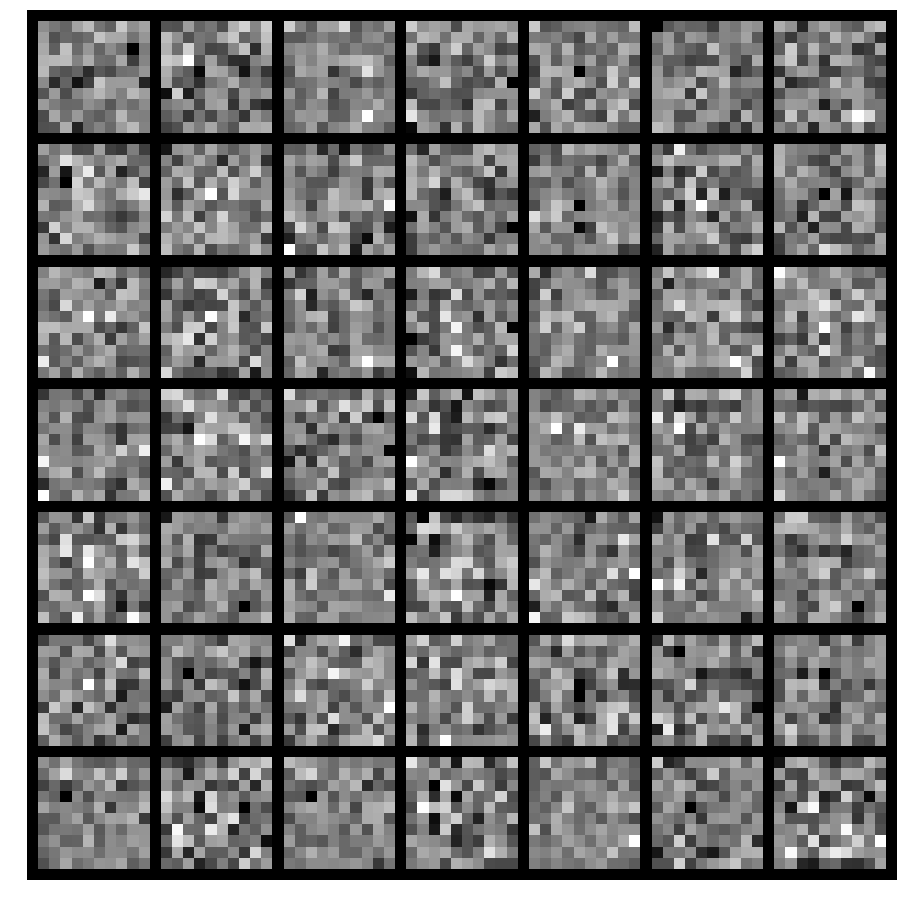

In [21]:
displayData(theta2);

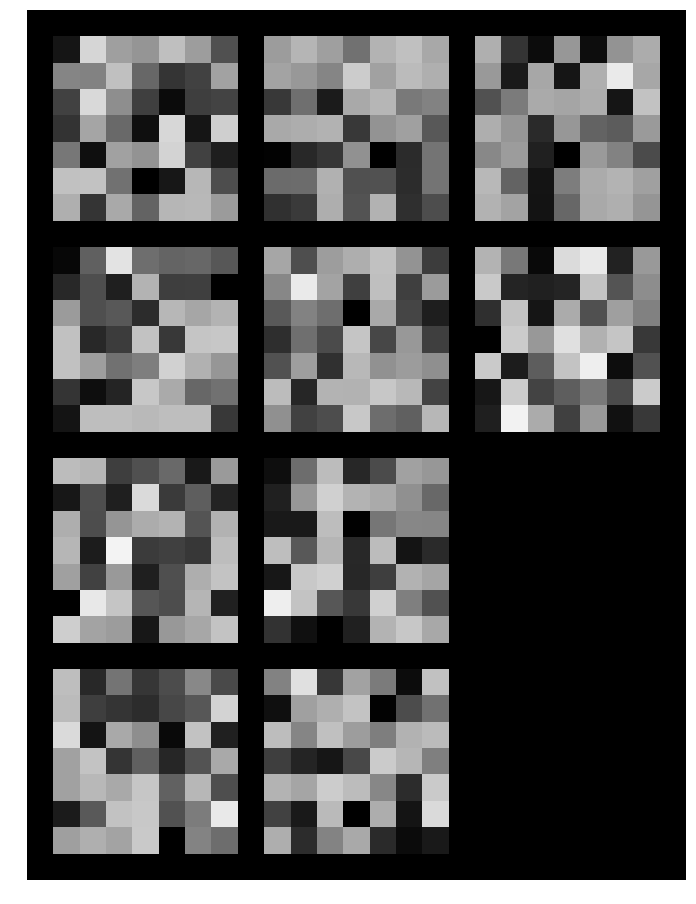

In [22]:
displayData(theta3);

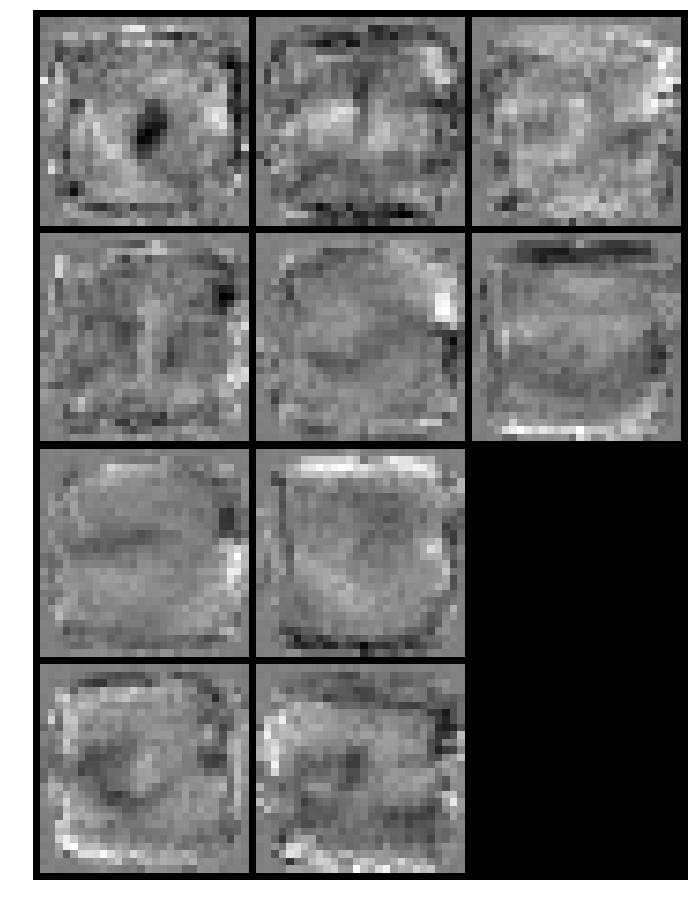

(<matplotlib.image.AxesImage at 0x1816ca6bc18>,
 array([[-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -0.03073894, -0.09972516, ..., -0.0457076 ,
          0.03125566, -1.        ],
        [-1.        , -0.0239823 , -0.01790208, ...,  0.02923476,
          0.01018859, -1.        ],
        ..., 
        [-1.        , -0.03210113, -0.00583552, ..., -1.        ,
         -1.        , -1.        ],
        [-1.        ,  0.03279978, -0.01203158, ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ]]))

In [23]:
displayData(theta)

<img src='./images/ann.jpg'>
Interpreting the weights are tough and not at all obvious. Sometimes this can be done, but more often than not the "concolusions" that a macine learning model draws will not make sense to human interpretation.

# A stand-alone training model
The above model can be compactly written as

In [24]:
from sklearn.preprocessing import LabelBinarizer
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense

# create preprocessor
categorical_transform = LabelBinarizer().fit(np.arange(10))

# load and transform data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X  = X_train.reshape(60000,784) / 255
Xt = X_test.reshape( 10000,784) / 255
y  = categorical_transform.transform(y_train)
yt = categorical_transform.transform(y_test)

# create model
model = Sequential()
model.add(Dense(input_dim=784, units = 100, activation='relu'))
model.add(Dense(               units =  50, activation='relu'))
model.add(Dense(               units =  10, activation='softmax'))

# compile model
model.compile(optimizer= 'adam',                     
              loss     = 'categorical_crossentropy',
              metrics  = ['accuracy'])

# train model
model.fit(X, y,
         epochs=10,
         batch_size=100,
         validation_data=(Xt,yt))


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 42us/step - loss: 0.3381 - acc: 0.9032 - val_loss: 0.1786 - val_acc: 0.9483

# Predicting your own handwriting

**Optional:** you will write one or more numbers on a piece of paper, take a picture using your webcam and try and classify these digits using the above model.

First we will need to get the raw data from the webcam. You will need ot have either opencv (recommended: windows users) or pygame (recommended: linux users) installed on your system for this to work.

In [25]:
import numpy as np

def get_webcam_image():
    try:
        import cv2
        # import dafdfdf
        webcam = cv2.VideoCapture(0)
        ok,img = webcam.read()
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except ImportError:
        from pygame import camera
        from pygame.surfarray import pixels3d
        camera.init()
        cameras = camera.list_cameras()
        print('Using camera {}'.format(cameras[0]))
        webcam = camera.Camera(cameras[0], (640,480))
        webcam.start()
        img = webcam.get_image()
        webcam.stop()
        return np.swapaxes(pixels3d(img),0,1)


In [26]:
import matplotlib.pyplot as plt

I = get_webcam_image()
print(I.shape)
plt.imshow(I)
plt.show()


ImportError: cannot import name '_camera'

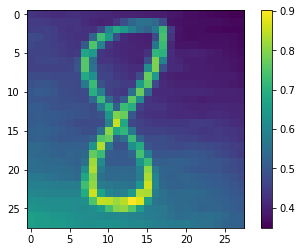

In [25]:
from scipy.misc import imresize
x = imresize(255-I[:,:,1], (28,28)) / 255.0 # remember to rescale the image to the range [0,1]
plt.imshow(x)
plt.colorbar()
plt.show()

In [26]:
# do a prediction using our model
prediction = model.predict(x.reshape(1,28*28)) # remember to roll the image data into a vector

# the prediction is a vector of 10 (output nodes) with % probability of that being the shown digit (softmax function)
print(prediction)
print()
print('{:.2%} chance of this being a {}'.format(prediction[0,8], 8))
best_guess = np.argmax(prediction[0,:])
print('{:.2%} chance of this being a {}'.format(prediction[0,best_guess], best_guess))

[[  2.74595164e-04   2.60551076e-07   3.84332895e-01   4.49080497e-01
    7.82219914e-27   1.66311666e-01   5.59188162e-09   6.80525775e-11
    5.58948514e-08   9.72961642e-11]]

0.00% chance of this being a 8
44.91% chance of this being a 3


**Exercise:** Explain why the model performs so poorly to data aquired from the webcam